# PULSE profile upscaling

This notebook contains the steps and explanation for 'upscaling' *fractional* power yearprofiles to *absolute* power yearprofiles (in kW) for use in the Gaia 8 GM-typegenerator.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import plotly.express as px

#### Specify input and output locations

First, we specify the paths for input and output.

*folder_scaled_profiles* contains files with fractional yearprofiles for 400 samples. There is a seperate file for each cluster-bin combination. Each sample contains the fraction of annual power usage per quarter for that sample (365/366 days x 24 hours x 4 quarters = 35.040/35.136 values per sample). Samples are stored in .parquet format for efficient storage and io.

*folder_power_profiles* (after running this script) contains the yearprofiles 'scaled up' to the unit of kilowatts, by multiplying the fractions of each sample with a suitable 'standaardjaarverbruik' value (in kWh). Samples are stored in .parquet format for efficient storage and io.

*path_ean_sjv* contains 'standaardjaarverbruik' values for many connections, including identifiers for that connection's cluster and bin. Upscaling is performed using a selection of these values. This file is provided by team Inzicht in Basislast.

In [4]:
folder_scaled_profiles = Path("../custom-file-systems/efs/fs-01aa7e2484bb89cc8/pulse/2023/e1v-fractions")
folder_power_profiles = Path("../custom-file-systems/efs/fs-01aa7e2484bb89cc8/pulse/2023/e1v-active-power")
path_ean_sjv = Path("../custom-file-systems/efs/fs-01aa7e2484bb89cc8/pulse/2023/cluster_profiles_samples_ean_profile_bin_sjv.parquet")

#### Create the SJV list for upscaling

In [5]:
eans_e1v_sjv_df = (pq.read_pandas(str(path_ean_sjv)).to_pandas()
                   .query("profiel.str.contains('E1_verbruik_cluster_')")
                   .assign(cluster=lambda x: x["profiel"].apply(lambda x: x[20:]))
                   .astype({"bin": int, "cluster": int})
                   .astype({"bin": str, "cluster": str})
                   .loc[:, ["cluster", "bin", "ean", "sjv_kwh"]]
                   .reset_index(drop=True)
                   )

eans_e1v_sjv_df.head()

,cluster,bin,ean,sjv_kwh
0,1,4,871685900000103118,8567
1,1,4,871685900000133276,9722
2,1,4,871685900000210274,9565
3,1,4,871685900000211486,11782
4,1,4,871685900000236717,3953


#### Generate the training samples

The "GM-typegenerator" in Gaia 8 takes as input a set of power yearprofiles, each containing the average power (P, in kilowatts) value per 15 minute window for a period of (at least) one full calendar year. Year profiles are collected from smart meters by PULSE. For privacy reasons, PULSE can only share and distribute anonymized, e.g. fractional yearprofiles.
Therefore, we have to 'scale up' the fractional yearprofiles with a suitable 'standaardjaarverbruik (kWh)' to obtain yearprofiles for training Gaussian Mixture Models (GMMs).

The criteria for 'suitable' are defined as follows:
- the 'standaardjaarverbruik' used for upsacling a fractional sample has to come from the same cluster an bin as the fractional sample.
- the scaling up can not lead to yearprofiles with physically impossible power peaks, i.e. higher than:
  - for AC1: 3 x 25A x 230V = 17.25 kilowatts
  - for AC2: 3 x 80A x 230V = 55.2 kilowatts

Additionaly, the distribution of the 'standaardjaarverbruik' values in the training samples for a cluster-bin should ideally be similar to the distribution of 'standaardjaarverbruik values in the real world (i.e. the ean_sjv list).


In [5]:
# set random seed for reproducable results.
np.random.seed(12345)

# specify the number of clusters and bins per cluster.
n_clusters = 12
n_bins = 4

max_power_kw = 17.25
max_power_kw_quarter = max_power_kw / 4

for cluster in range(1, n_clusters + 1, 1):
    for bin in range(1, n_bins + 1, 1):
        print(f"upscaling samples for cluster: {cluster} bin: {bin}")
        scaled_df = pq.read_pandas(str(folder_scaled_profiles) +
                                   f"/e1v_cluster_{cluster}_bin_{bin}_normalized.parquet").to_pandas()

        power_df = scaled_df.copy()

        max_sjv_series = (max_power_kw_quarter / scaled_df.iloc[:, 3:].max(axis=0)).reset_index(drop=True)

        cluster_str = str(cluster)
        bin_str = str(bin)

        sjv_series = eans_e1v_sjv_df.query("cluster == @cluster_str and bin == @bin_str")["sjv_kwh"]

        for sample in range(400):
            max_sjv = max_sjv_series[sample]

            # sample sjv
            # no 0kWh values (bin 1 only), and no peaks > max_power_kw
            eligible_sjv_series = sjv_series[(sjv_series > 0) & (sjv_series < max_sjv)]

            if eligible_sjv_series.shape[0] > 0:
                sjv_sample = eligible_sjv_series.sample(1, random_state=np.random.randint(0, 10000)).values
                power_df.iloc[:, sample + 3] = power_df.iloc[:, sample + 3] * sjv_sample * 4
            else:
                power_df.iloc[:, sample + 3] = power_df.iloc[:, sample + 3] * max_sjv * 4
                # only for cluster 3 bin 4 sample 208

        power_df.iloc[:, 2:].to_parquet(str(folder_power_profiles) + f"/e1v_cluster_{cluster}_bin_{bin}.parquet", index=False)

upscaling samples for cluster: 1 bin: 1
upscaling samples for cluster: 1 bin: 2
upscaling samples for cluster: 1 bin: 3
upscaling samples for cluster: 1 bin: 4
upscaling samples for cluster: 2 bin: 1
upscaling samples for cluster: 2 bin: 2
upscaling samples for cluster: 2 bin: 3
upscaling samples for cluster: 2 bin: 4
upscaling samples for cluster: 3 bin: 1
upscaling samples for cluster: 3 bin: 2
upscaling samples for cluster: 3 bin: 3
upscaling samples for cluster: 3 bin: 4
upscaling samples for cluster: 4 bin: 1
upscaling samples for cluster: 4 bin: 2
upscaling samples for cluster: 4 bin: 3
upscaling samples for cluster: 4 bin: 4
upscaling samples for cluster: 5 bin: 1
upscaling samples for cluster: 5 bin: 2
upscaling samples for cluster: 5 bin: 3
upscaling samples for cluster: 5 bin: 4
upscaling samples for cluster: 6 bin: 1
upscaling samples for cluster: 6 bin: 2
upscaling samples for cluster: 6 bin: 3
upscaling samples for cluster: 6 bin: 4
upscaling samples for cluster: 7 bin: 1


#### Training the Gaussian Mixture type

The GM-type parameters for each cluster-bin are trained using the builtin GM type generator of the software package Gaia 8 (desktop version). 

As input, use the sample yearprofiles generated above.

Note: Gaia 8 does not accept parquet files as input, so the sample files must first be converted to csv format.

#### Appendix: Example of fractional and power yearprofiles

In [5]:
scaled_df.head()

,cluster,bin,timestamp,1,2,3,4,5,6,7,...,391,392,393,394,395,396,397,398,399,400
0,12,4,2023-01-01 00:00:00,0.000007,0.000008,0.000012,0.000005,0.000015,0.000044,0.000040,...,0.000023,0.000029,0.000015,0.000085,0.000009,0.000029,0.000130,0.000013,0.000013,0.000050
1,12,4,2023-01-01 00:15:00,0.000008,0.000008,0.000014,0.000005,0.000014,0.000018,0.000040,...,0.000024,0.000017,0.000047,0.000099,0.000003,0.000029,0.000129,0.000012,0.000013,0.000058
2,12,4,2023-01-01 00:30:00,0.000008,0.000008,0.000012,0.000004,0.000013,0.000037,0.000039,...,0.000020,0.000029,0.000087,0.000039,0.000033,0.000029,0.000129,0.000032,0.000016,0.000075
3,12,4,2023-01-01 00:45:00,0.000008,0.000011,0.000014,0.000004,0.000013,0.000031,0.000064,...,0.000028,0.000026,0.000038,0.000037,0.000006,0.000029,0.000129,0.000028,0.000019,0.000057
4,12,4,2023-01-01 01:00:00,0.000008,0.000109,0.000133,0.000004,0.000017,0.000021,0.000015,...,0.000028,0.000022,0.000013,0.000016,0.000003,0.000029,0.000129,0.000013,0.000017,0.000030


In [6]:
power_df.head()

,cluster,bin,timestamp,1,2,3,4,5,6,7,...,391,392,393,394,395,396,397,398,399,400
0,12,4,2023-01-01 00:00:00,0.369961,0.439821,0.368524,0.205659,0.628943,1.526765,1.320043,...,0.790930,1.101265,0.464770,3.035480,0.244867,0.748556,3.426879,0.480319,0.392016,1.958195
1,12,4,2023-01-01 00:15:00,0.375567,0.458147,0.449419,0.210442,0.588195,0.644170,1.333889,...,0.838010,0.662480,1.490214,3.525874,0.088877,0.748556,3.398658,0.473601,0.392016,2.277703
2,12,4,2023-01-01 00:30:00,0.375567,0.488690,0.368524,0.160223,0.563391,1.313437,1.306196,...,0.682648,1.084058,2.788618,1.384278,0.885147,0.752181,3.394626,1.225989,0.470420,2.953026
3,12,4,2023-01-01 00:45:00,0.375567,0.616972,0.458407,0.167397,0.540360,1.087559,2.132377,...,0.969831,0.980815,1.206188,1.322203,0.155989,0.759431,3.386563,1.071481,0.545919,2.234133
4,12,4,2023-01-01 01:00:00,0.375567,6.395737,4.224538,0.150657,0.728157,0.723645,0.512324,...,0.960416,0.847458,0.431572,0.564885,0.079808,0.770306,3.402689,0.493755,0.490746,1.166687


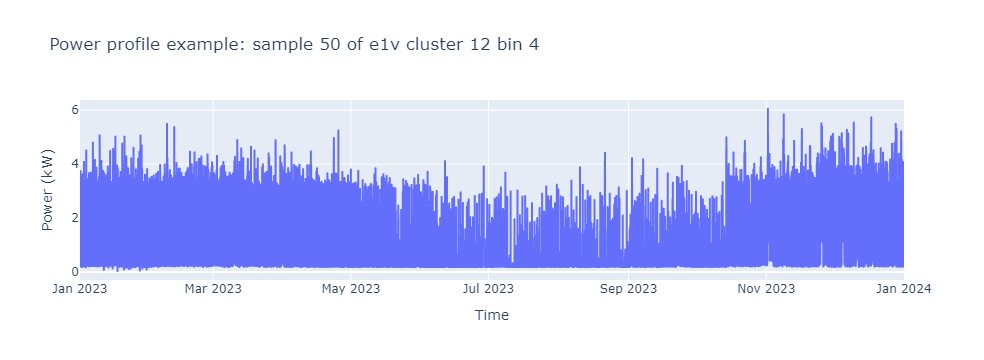

In [17]:
px.line(power_df,
        x="timestamp",
        y="50",
        title="Power profile example: sample 50 of e1v cluster 12 bin 4",
        labels={"timestamp": "Time", "50": "Power (kW)"})